In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def clean_csv_data(path, cols):
    # 使用pd.read_csv读取CSV数据并将其存储到DataFrame中
    df = pd.read_csv(path)
    
    # 选择指定的列
    df = df[cols]
    
    # 删除包含缺失值的行
    df.dropna(inplace=True)
    
    # 如果需要筛选 'availability_365' 大于等于30的行，可以取消下一行的注释
    df = df[df['availability_365'] >= 30]
    
    return df

In [3]:
years = ['2020', '2021', '2022', '2023']
csv_files=["C:/Users/47692/CASA/FSDS_Groupwork/FSDS_GroupAssignment_Data/Data/listings_2020.csv",
"C:/Users/47692/CASA/FSDS_Groupwork/FSDS_GroupAssignment_Data/Data/listings_2021.csv",
"C:/Users/47692/CASA/FSDS_Groupwork/FSDS_GroupAssignment_Data/Data/listings_2022.csv",
"C:/Users/47692/CASA/FSDS_Groupwork/FSDS_GroupAssignment_Data/Data/listings_2023.csv"]

cols = ['id', 'last_scraped',  'host_id', 'host_name', 'host_is_superhost', 
        'host_listings_count', 'host_total_listings_count',  'latitude', 'longitude', 
        'property_type', 'room_type', 'accommodates', 'price', 'minimum_nights', 'maximum_nights', 
        'availability_365', 'number_of_reviews', 
        'first_review', 'last_review', 'review_scores_rating', 'reviews_per_month']


for year, csv_file in zip(years, csv_files):
    df = clean_csv_data(csv_file, cols)
    output_file = f"D:/FSDS project/Data/cleaned_data_{year}.csv"

    df.to_csv(output_file, index=False)


C:\Users\47692\AppData\Local\Temp\ipykernel_23572\3160282293.py:3: DtypeWarning: Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


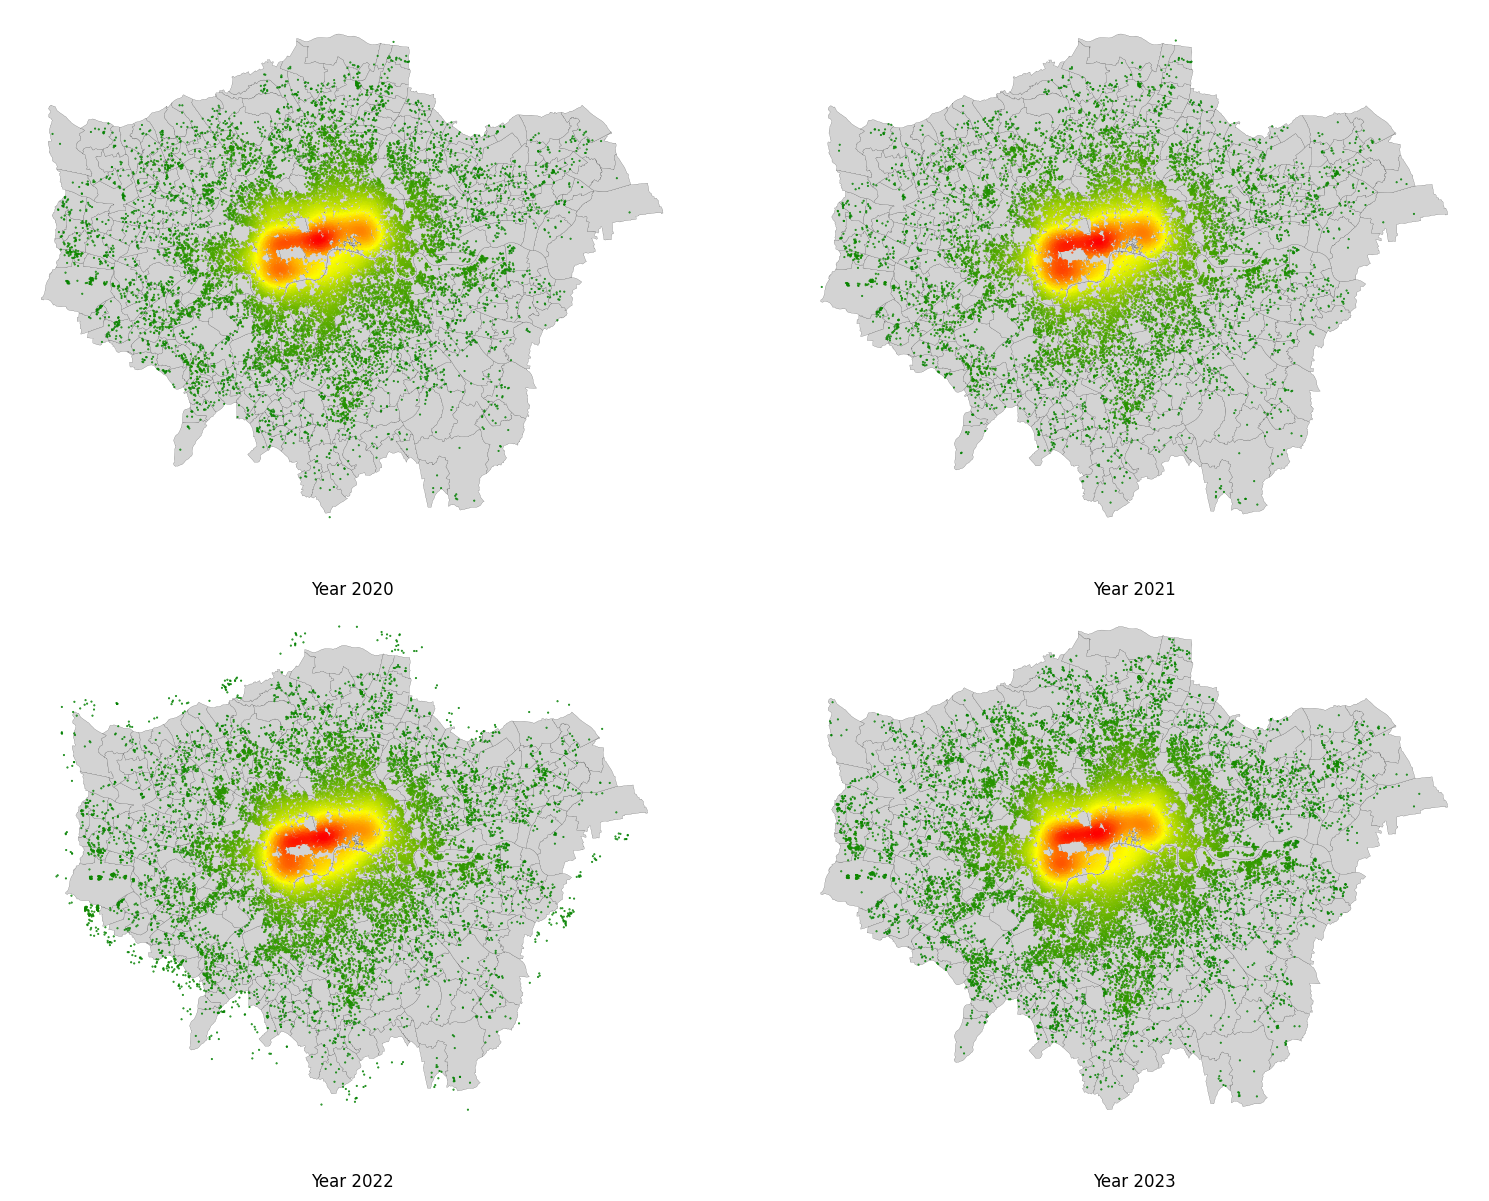

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()
# 读取矢量图
london_vector_map = gpd.read_file("D:/FSDS project/Data/London_Ward/London_Ward.shp")
london_vector_map = london_vector_map.to_crs('EPSG:4326')
for i, year in enumerate(years):  # 使用enumerate获取年份索引
    # 读取清洗后的数据
    csv_file = f"D:/FSDS project/Data/cleaned_data_{year}.csv"
    df = pd.read_csv(csv_file)
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    geo_df = gpd.GeoDataFrame(df, geometry=geometry)
    # 计算核密度估计
    x = df['longitude']
    y = df['latitude']
    xy = np.vstack([x, y])
    kde = gaussian_kde(xy, bw_method='silverman')
    kde_values = kde(xy)

    # 创建颜色映射
    colors = [(0, 'green'), (0.5, 'yellow'), (1, 'red')]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

    # 将密度值归一化并映射到颜色
    norm_kde_values = kde_values / max(kde_values)
    colors = cmap(norm_kde_values)

    # 绘制地图
    ax = axes[i]

    # 绘制伦敦矢量图
    london_vector_map.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.1)

    # 绘制缩小后的热力图点
    geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='EPSG:4326')
    geo_df.plot(ax=ax, marker='o', color=colors, markersize=0.25)

    # 添加年份标签
    ax.text(0.5, -0.1, f"Year {year}", size=12, ha='center', transform=ax.transAxes)

    # 调整坐标轴可见性
    ax.set_axis_off()

plt.tight_layout()
plt.show()


In [13]:
# Define the CRS as British National Grid (EPSG:27700)
bn_grid_crs = 'EPSG:27700'
# Initialize dictionaries to store the count and density of points per ward
Borough_density = {}
london_vector_map2 = gpd.read_file("D:/FSDS project/Data/London_Borough_Excluding_MHW/London_Borough_Excluding_MHW.shp")
london_vector_map2 = london_vector_map2.to_crs(bn_grid_crs)



for year in years:
    # Read the cleaned data for the current year
    csv_file = f"D:/FSDS project/Data/cleaned_data_{year}.csv"
    df = pd.read_csv(csv_file)

    # Create a GeoDataFrame from the longitude and latitude columns
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    geo_df = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

    # Reproject the GeoDataFrame to British National Grid (EPSG:27700)
    geo_df = geo_df.to_crs(bn_grid_crs)

    # Perform a spatial join to associate each point with a ward
    joined = gpd.sjoin(geo_df, london_vector_map2.to_crs(bn_grid_crs), how="inner", op="within")

    # Count the number of points in each ward
    borough_counts = joined['GSS_CODE'].value_counts().to_dict()
    
    # Calculate the density of points in each ward (points per square meter)
    for borough in borough_counts:
        borough_area_sqm = london_vector_map2[london_vector_map2['GSS_CODE'] == borough].to_crs(bn_grid_crs).geometry.area.iloc[0]  # Keep units in square meters
        Borough_density[borough] = borough_counts[borough] / borough_area_sqm  # Calculate density in points per square meter

    # Get the NAME column for each ward
    borough_names = london_vector_map2.set_index('GSS_CODE')['NAME'].to_dict()

    # Store the point count and density for this year, along with NAME and GSS_CODE
    borough_data = pd.DataFrame({
        'GSS_CODE': borough_names.keys(),
        'NAME': borough_names.values(),
        'COUNT': [borough_counts.get(code, 0) for code in borough_names.keys()],
        'DENSITY': [Borough_density.get(code, 0) for code in borough_names.keys()]
    })

    # Save the ward data to a CSV file for the current year
    borough_data.to_csv(f"D:/FSDS project/Data/borough_data_{year}.csv", index=False)


c:\Users\47692\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\47692\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\47692\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [14]:
import pandas as pd

# Load the borough_data DataFrames for each year
years = ['2020', '2021', '2022']
borough_data_files = [f"D:/FSDS project/Data/borough_data_{year}.csv" for year in years]
borough_data = [pd.read_csv(file) for file in borough_data_files]

# Read the "social-landlord-rents-borough.csv" file
rents_data = pd.read_csv("D:/FSDS project/Data/social-landlord-rents-borough.csv")

# Iterate through each year and modify the existing CSV files
for i, year in enumerate(years):
    # Select the specific year column from rents_data
    year_rent_data = rents_data[['New_Code', year]]
    
    # Merge ward_data with year_rent_data based on 'GSS_CODE' and 'New_Code'
    merged_data = borough_data[i].merge(
        year_rent_data,
        left_on='GSS_CODE',
        right_on='New_Code',
        how='left'
    )
    
    # Rename the newly added column to 'Rent_YEAR'
    merged_data.rename(columns={year: f'Rent_{year}'}, inplace=True)
    
    # Save the merged data to the corresponding CSV file
    merged_data.to_csv(borough_data_files[i], index=False)


In [ ]:
#print(rents_data.columns)
# 显示 'GSS_CODE' 列的数据类型
print(ward_data[0]['GSS_CODE'].dtype)


# 显示 'New_Code' 列的数据类型
print(ward_data[0]['GSS_CODE'].dtype)



object
object
